##스왑션(Swaption)
스왑션(Swaption)은 스왑을 매수할 수 있는 옵션을 의미합니다. 스왑션에는 두 가지 주요 유형이 있습니다:

1. 콜 스왑션 (payer swaption): 스왑의 고정 금리를 지급하고 변동 금리를 받는 옵션.

2. 풋 스왑션 (receiver swaption): 스왑의 고정 금리를 받고 변동 금리를 지급하는 옵션.

여기서는 블랙-숄즈 모델을 사용하여 간단한 콜 스왑션(payer swaption)을 구현해 보겠습니다.

In [2]:
import matplotlib.font_manager as fm

# Google Colab에 NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 설치된 폰트 확인 및 matplotlib에 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


<ipython-input-3-b8da9f3a9896>:48: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = np.std(floating_leg_payments - fixed_leg_payments) / np.mean(floating_leg_payments - fixed_leg_payments)  # 변동성 추정
<ipython-input-3-b8da9f3a9896>:16: RuntimeWarning: invalid value encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Swaption의 현재 가치: nan


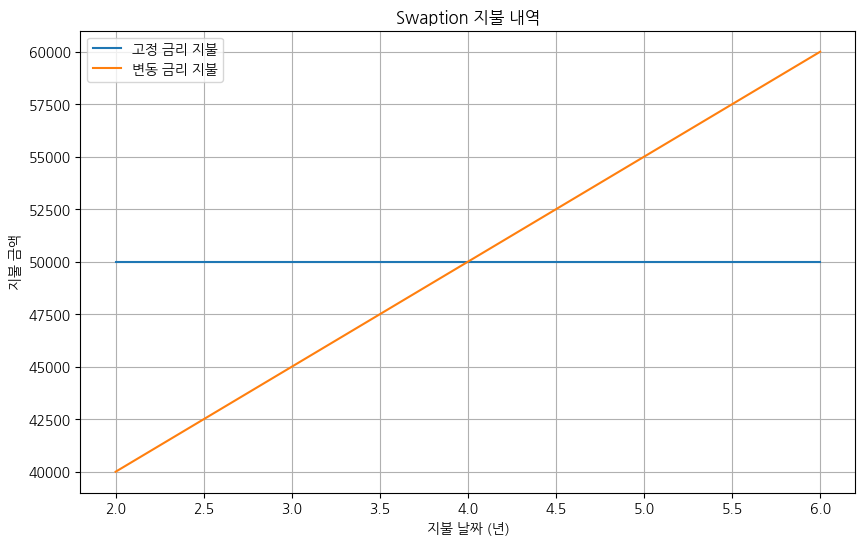

In [3]:
import numpy as np
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt

# 블랙-숄즈 모델을 사용하여 스왑션 가격 계산 함수
def swaption_price(S, K, T, r, sigma, option_type='call'):
    """
    S: 기초 자산의 현재 가격 (현재 스왑의 가치)
    K: 옵션 행사가격 (스왑의 고정 금리)
    T: 옵션의 만기 시간
    r: 무위험 이자율
    sigma: 변동성
    option_type: 'call' 또는 'put'
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

# 고정 금리 지불 계산 함수
def fixed_leg_payment(notional, fixed_rate, payment_dates, start_date):
    payments = notional * fixed_rate * np.diff(payment_dates, prepend=start_date)
    return payments

# 변동 금리 지불 계산 함수
def floating_leg_payment(notional, floating_rates, payment_dates, start_date):
    payments = notional * floating_rates * np.diff(payment_dates, prepend=start_date)
    return payments

# Swaption의 현재 가치 계산 함수
def swaption_value(notional, fixed_rate, floating_rates, start_date, payment_dates, discount_factors, strike_rate, option_type='call'):
    # 고정 금리 지불 계산
    fixed_leg_payments = fixed_leg_payment(notional, fixed_rate, payment_dates, start_date)

    # 변동 금리 지불 계산
    floating_leg_payments = floating_leg_payment(notional, floating_rates, payment_dates, start_date)

    # 현재 스왑의 가치 계산
    swap_value = np.sum((floating_leg_payments - fixed_leg_payments) * discount_factors)

    # 스왑션 가격 계산
    sigma = np.std(floating_leg_payments - fixed_leg_payments) / np.mean(floating_leg_payments - fixed_leg_payments)  # 변동성 추정
    swaption_val = swaption_price(swap_value, strike_rate, start_date, 0.05, sigma, option_type)

    return swaption_val

# 예시 데이터
notional = 1000000  # 명목 금액
fixed_rate = 0.05  # 스왑의 고정 금리 (5%)
floating_rates = np.array([0.04, 0.045, 0.05, 0.055, 0.06])  # 변동 금리
start_date = 1  # 스왑션의 만기 시간 (1년)
payment_dates = np.array([2, 3, 4, 5, 6])  # 지불 날짜 (스왑 시작 후 매년)
discount_factors = np.exp(-0.05 * (payment_dates - start_date))  # 할인율
strike_rate = 0.05  # 스왑션 행사가격 (5%)

# Swaption의 현재 가치 계산
swaption_val = swaption_value(notional, fixed_rate, floating_rates, start_date, payment_dates, discount_factors, strike_rate, option_type='call')
print(f"Swaption의 현재 가치: {swaption_val:.2f}")

# 시각화
fixed_leg_payments = fixed_leg_payment(notional, fixed_rate, payment_dates, start_date)
floating_leg_payments = floating_leg_payment(notional, floating_rates, payment_dates, start_date)

plt.figure(figsize=(10, 6))
plt.plot(payment_dates, fixed_leg_payments, label='고정 금리 지불')
plt.plot(payment_dates, floating_leg_payments, label='변동 금리 지불')
plt.xlabel('지불 날짜 (년)')
plt.ylabel('지불 금액')
plt.title('Swaption 지불 내역')
plt.legend()
plt.grid(True)
plt.show()
